In [1]:
# Load libraries

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
import xesmf as xe
from scipy.interpolate import griddata

ModuleNotFoundError: No module named 'gcsfs'

# Try accessing a dataset

#### Please read these first!:
More information on datasets here: https://computing-docs.readthedocs.io/en/latest/load_with_catalog.html 

This link contains more information on what CMIP6 data looks like and what all the labels mean: https://computing-docs.readthedocs.io/en/latest/download_cmip.html

Cristi has many model output files within his directory `/data/keeling/a/cristi/a/esm_data`. We're going to be using a lot of CMIP6 data, which is from the Climate Model Intercomparison Project phase 6. There's variable output from many different models under different scenarios within CMIP6. This data is kept in `/data/keeling/a/cristi/a/esm_data/cmip6`.

You can type `cd /data/keeling/a/cristi/a/esm_data/cmip6` into your terminal to look at the directory.

Once you're in the CMIP6 directory, you'll see all of the CMIP6 models. We'll be using data from any and all of the models, so feel free to pick whichever you'd like! I suggest using CESM2, CanESM5, BCC-CSM2-MR, or GFDL-ESM4 since they've given me the least trouble. 

Type `cd [modelname]` to go into that directory.

Once you're within a model directory, you'll see a bunch of experiments that the model has simulated.

The two experiments that we'll use the most are:
 - piControl - This is a control simulation, with everything kept to preindustrial conditions.
 - historical - This is a simulation with conditions following those in observations from 1850~2014. 

We'll be using piControl the most, so type `cd piControl`.

Typically you'll be taken to one or two subdirectories with a name like `r1i1p1f1`. Feel free to pick either one. This is the variant number, and we usually pick `r1i1p1f1`. 

Next, you'll be taken to the actual datasets! The first part of the file name is the variable. The variables we'll be using the most are:
 - tas - Surface air temperature. This is the air temperature just a couple meters off the ground.
 - ts - Surface skin temperature. This is the actual temperature of the surface.
 - rlds, rlut, rsds, hfls, hfss, rsdt, rsut - These are different radiative and heat fluxes. We'll go over this later.
 
Try following the load_with_catalog tutorial linked at the top to load a TAS dataset and then plot the time mean surface skin temperature over the whole globe.

In [3]:
# Following the tutorial up above, here's the catalog for the CMIP6 data

cat = pd.read_csv('/data/keeling/a/cristi/a/esm_data/cmip6_catalog.csv')
cat

,activity_id,branch_method,branch_time_in_child,branch_time_in_parent,experiment,experiment_id,frequency,grid,grid_label,institution_id,...,standard_name,long_name,units,vertical_levels,init_year,start_time,end_time,time_range,path,version
0,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,surface_upward_latent_heat_flux,Surface Upward Latent Heat Flux,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
1,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,surface_upward_sensible_heat_flux,Surface Upward Sensible Heat Flux,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
2,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,surface_downwelling_longwave_flux_in_air,Surface Downwelling Longwave Radiation,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
3,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,surface_upwelling_longwave_flux_in_air,Surface Upwelling Longwave Radiation,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
4,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,toa_outgoing_longwave_flux,TOA Outgoing Longwave Radiation,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11609,ScenarioMIP,standard,59400.0,59400.0,update of RCP8.5 based on SSP5,ssp585,mon,Native N96 grid; 192 x 144 longitude/latitude,gn,MOHC,...,surface_downwelling_shortwave_flux_in_air,Surface Downwelling Shortwave Radiation,W m-2,1.0,NaN,2015-01-16 00:00:00,2100-12-16 00:00:00,2015-01-16 00:00:00-2100-12-16 00:00:00,/data/cristi/a/cristi/esm_data/cmip6/UKESM1-0-...,v0
11610,ScenarioMIP,standard,59400.0,59400.0,update of RCP8.5 based on SSP5,ssp585,mon,Native N96 grid; 192 x 144 longitude/latitude,gn,MOHC,...,toa_incoming_shortwave_flux,TOA Incident Shortwave Radiation,W m-2,1.0,NaN,2015-01-16 00:00:00,2100-12-16 00:00:00,2015-01-16 00:00:00-2100-12-16 00:00:00,/data/cristi/a/cristi/esm_data/cmip6/UKESM1-0-...,v0
11611,ScenarioMIP,standard,59400.0,59400.0,update of RCP8.5 based on SSP5,ssp585,mon,Native N96 grid; 192 x 144 longitude/latitude,gn,MOHC,...,surface_upwelling_shortwave_flux_in_air,Surface Upwelling Shortwave Radiation,W m-2,1.0,NaN,2015-01-16 00:00:00,2100-12-16 00:00:00,2015-01-16 00:00:00-2100-12-16 00:00:00,/data/cristi/a/cristi/esm_data/cmip6/UKESM1-0-...,v0
11612,ScenarioMIP,standard,59400.0,59400.0,update of RCP8.5 based on SSP5,ssp585,mon,Native N96 grid; 192 x 144 longitude/latitude,gn,MOHC,...,toa_outgoing_shortwave_flux,TOA Outgoing Shortwave Radiation,W m-2,1.0,NaN,2015-01-16 00:00:00,2100-12-16 00:00:00,2015-01-16 00:00:00-2100-12-16 00:00:00,/data/cristi/a/cristi/esm_data/cmip6/UKESM1-0-...,v0


As an example to load data, try looking at the example below. 

This example takes rsdt data from CESM2 run at monthly intervals for CMIP6. It also only returns the first dataset that corresponds to what we asked for (head(1)).

In [9]:
path_rsdt_control = cat.loc[(cat['variable_id']=='rsdt') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['source_id']=='CESM2') &
               (cat['experiment_id'].str.contains('Control'))].head(1)['path'].to_list()
path_rsdt_control

['/data/cristi/a/cristi/esm_data/cmip6/CESM2/piControl/r1i1p1f1/rsdt_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc']

In [10]:
ds = xr.open_dataset(path_rsdt_control[0])
ds

/data/keeling/a/jyoon83/miniconda3/envs/paleoproj/lib/python3.12/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (time: 1188, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 0001-01-15 12:00:00 ... 0099-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    rsdt       (time, lat, lon) float32 ...
    time_bnds  (time, nbnd) object ...
    lat_bnds   (lat, nbnd) float32 ...
    lon_bnds   (lon, nbnd) float32 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                3
    cesm_casename:          b.e21.B1850.f09_g17.CMIP6-piControl.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-20T21:36:37Z
    ...                     ...
    variable_id:            rsdt
    variant_info:           CMIP6 CESM2 piControl experiment with CAM6, inter...
    variant_label:          r1i1p1f1
    branch_time_in_parent:  48545.0
    branch_time_in_child:   0.0
    branch_method:          standard

Try doing something similar for skin temperature! Then, take a mean over time in order to get mean surface temperature over the whole globe, and then plot the corresponding map.

In [11]:
path_ts_control = cat.loc[(cat['variable_id']=='ts') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['source_id']=='CESM2') &
               (cat['experiment_id'].str.contains('Control'))].head(1)['path'].to_list()
path_ts_control

['/data/cristi/a/cristi/esm_data/cmip6/CESM2/piControl/r1i1p1f1/ts_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc']

In [12]:
ds2 = xr.open_dataset(path_ts_control[0])
ds2

/data/keeling/a/jyoon83/miniconda3/envs/paleoproj/lib/python3.12/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (time: 1188, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 0001-01-15 12:00:00 ... 0099-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    ts         (time, lat, lon) float32 ...
    time_bnds  (time, nbnd) object ...
    lat_bnds   (lat, nbnd) float32 ...
    lon_bnds   (lon, nbnd) float32 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                3
    cesm_casename:          b.e21.B1850.f09_g17.CMIP6-piControl.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-20T21:36:28Z
    ...                     ...
    variable_id:            ts
    variant_info:           CMIP6 CESM2 piControl experiment with CAM6, inter...
    variant_label:          r1i1p1f1
    branch_time_in_parent:  48545.0
    branch_time_in_child:   0.0
    branch_method:          standard

In [26]:
#taking mean over time to get mean surface temp over whole globe
#ds2_gb = ds2.ts.groupby('time.month') #grouped by month
ds2_mean = ds2.ts.mean('time') #applying mean to the time dimension of the data variable ts
ds2_mean

<xarray.DataArray 'ts' (lat: 192, lon: 288)>
array([[222.40233, 222.40239, 222.40233, ..., 222.40239, 222.40236,
        222.40236],
       [222.95312, 222.91937, 222.7833 , ..., 222.97911, 222.97398,
        222.9646 ],
       [223.55782, 223.52147, 223.50378, ..., 223.76112, 223.71642,
        223.65411],
       ...,
       [255.48622, 255.50177, 255.51631, ..., 255.44547, 255.45828,
        255.471  ],
       [255.38426, 255.39062, 255.39713, ..., 255.36409, 255.37115,
        255.3778 ],
       [255.25745, 255.25818, 255.2589 , ..., 255.2551 , 255.25592,
        255.25679]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

Question: How does taking the mean in the time dimension calculate the mean of surface temp over the whole globe? Is it because it's taking the time dimension of the ts data variable and taking the mean of that data variable then over each time aspect it has that also correlates to the ts data variable's other dimensions of lat/lon? (I think I'm just not understanding the complexities of the dimensions...)

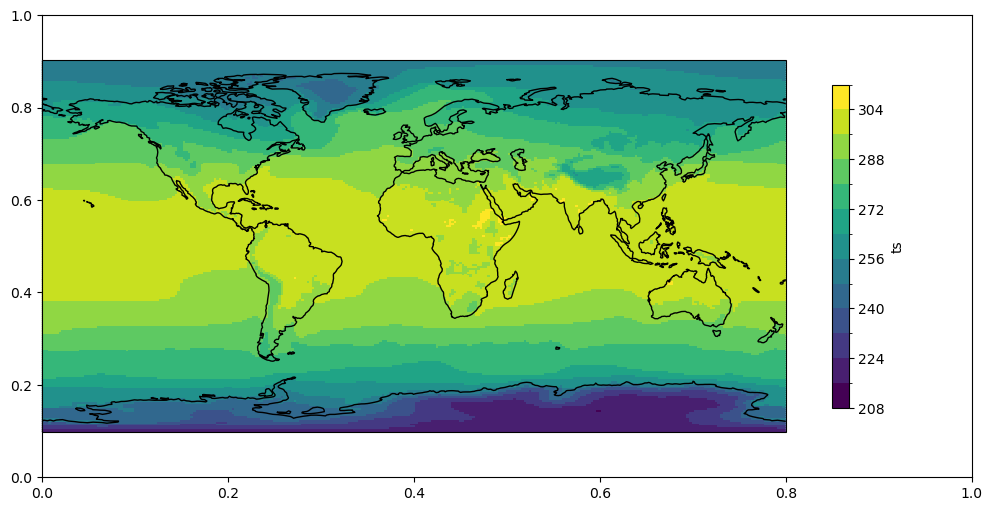

In [74]:
#plotting the corresponding map for that
#using cartopy to create a map base
fig, ax = plt.subplots(figsize = (12, 6))
ax = plt.subplot(projection = ccrs.PlateCarree())
ax.set_title('Mean Surface Temperature over Globe')
ax.set_ylabel('lon')
ax.set_xlabel('lat')
ax.coastlines()
#how do i set a contour mask over the cartopy map so it isn't goofy looking? i tried :')
ds2_mean.plot(ax=ax, transform = ccrs.PlateCarree(), levels = 15, cbar_kwargs = {"shrink": 0.7})